# Linear Polymers Simulation Project
Examining segments length distribution through a linear cut
---


$\text{Theory - Main formulas:}\\[2em]$



$\text{(1) }\left\langle \mathbf{r}^2 \right\rangle = l^2 N\\[1em]$

$\text{(2)  }S_{ij} = \frac{1}{N}\sum_{k=1}^N x_i^{(k)}x_j^{(k)}, R_{g}^2 = \text{tr}(S)\\[1em]$

$\text{(3)  }I_{ij} = \sum_{k=1}^N m_k(||r_k||^2 \delta_{ij}-x_i^{(k)}x_j^{(k)})\\[1em]$

$\text{(4)  }\mathbf{r}_{cm} = \frac{1}{M}\int_c \lambda(\mathbf{r})\mathbf{r}\mathrm{d}l \, =\frac{1}{N}\sum_{i=1}^{N-1} \frac{\mathbf{r_i} + \mathbf{r_{i+1}}}{2}\\[1em]$

$\text{(5) }P_{0, 1D}(2n) = \frac{1}{2^{2n}} {2n \choose n}\approx \frac{1}{\sqrt{\pi n}}\\[1em]$

$\text{(6) }F(t) = \sqrt\frac{\tau}{2\pi t^{3}}\approx t^{-\frac{3}{2}}\\[2em]$

$\mathbf{r}\text{ - end to end vector.}$

$l\text{ - a unit step.}$

$N\text{ - number of steps.}$

$S \text{ - gyration tensor.}$

$I \text{ - Inertia tensor.}$

$R_{g}^2 \text{ - radius of gyration.}$

$\mathbf{r}_{cm} \text{ - center of mass vector.}$

* Since the i-th monomer is a linear segment: $\mathbf{m_i} = \mathbf{r_i} - \mathbf{r_{i+1}}$ of a constant length we can easily refer each segment's cm as an effective singular point, then calculate $\mathbf{r}_{cm}$ by using the descrete formula.

$P_{0, 1D}(2n) \text{ - the probability of a 1D random-walk return to the origin in 2n steps.}$

$F(t) \text{ - the first return time distribution of a 1D random walk }(\tau=\Delta t = \frac{t}{N} \text{ is the time interval per step} ).$




# Basic assumptions:

The Polymer:


*   Modeling a single static linear-polymer ideal-chain as a 2D random-walk, of a fixed length step, with uniformly-distributed direction choosing.
*   Alowing self crossing
*   N is finite, although N>>1
*   The problem is scalable, means that the statistical properties are independent on the unit step. Thus, we choose an arbitrary length: l=1

The Cut:

*   Assuming a single linear continuous cut, of the form: y = ax + b
*   Forcing the cut to intersect the polymer through at least one point (e.g: cm, head)
*   The distribution samples dataset was driven from a single generated polymer, and randomized set of cuts (by uniformly choosing an angle between $[0,2\pi)$ and defining a fixed point).
I claim it is much complicated and redundant to try the opposite - a constant cut and randomized polymers.










# Conclusions:


*   The segments' length distribution in the log scale (both for x,y) present a linear behavior. Thus, we get a power law:
\begin{align}
        log(y) = a \cdot log(x) + b \leftrightarrow y = c \cdot x^a; c = e^b
    \end{align}

*   The simulation presents that $a\to -1.43$, independently of the chosen fixed point.

*   The simulation presents the inequality of $b_{cm} < b_{head}$, means that the distribution is more extreme towards the origin, when crossing the head, in comparison to the cm.

*   There is no correlation between the distribution parameters (linear regression for the histogram - ax + b) and the chosen principle-axis (main axis vs secondary axis), through the center of mass (an intuition: try choosing the main axes perpendicular to a lacing polymer, vs choosing the secondary axes through a zig-zag polymer). I claim that the gyration tensor, $S$, contains insufficient information for the above question.

*  The gyration tensor, $S$, defines the anisotropy of the polymer: the larger the eigenvalue, the wider the polymer perpendicular to the axis direction.


# The Code:

In [45]:
%matplotlib inline
%matplotlib widget

import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import matplotlib.mlab as mlab
from numpy.lib import stride_tricks


def get_angle_from_vec(vec):
    return np.arctan(vec[1]/vec[0])

random.seed(151)

In [32]:
class Monomer:
    def __init__(self, l, x, y, p1=None, angle = np.random.uniform(0, 2 * np.pi)):  # defining the very basic units
        self.l = l
        self.num = 0 # the serial number of the monomer in the polymer
        self.angle = angle

     # "p0___p1" is a single monomer
        self.p0 = [x, y]  # p0 = (x0,y0)
        if p1 is None:
          self.p1 = [self.p0[0] + (self.l * np.cos(self.angle)),
                    self.p0[1] + (self.l * np.sin(self.angle))]  # p1 = (x1,y1)
        else:
          self.p1 = p1

    def __repr__(self):
        return "l = " + str(self.l) + ", num = " + str(self.num) + \
               ", p0 = " + str(np.around(self.p0,2)) + ", p1 = " + str(np.around(self.p1,2))

In [33]:
class Polymer:
    def __init__(self, l=1, n=1000, arr = None):  # defining the very basic units of the polymer
        self.l = l # length of a monomer
        self.n = n  # num of monomers, the length of the polymer is then l * n
        self.p_head = [0,0] # p_head = (x,y), initial coordinates
        self.p_tail = [0,0] # p_tail = (x,y), final coordinates
        self.arr = np.zeros((self.n, 2)) # array of n monomer's coordinates.
        self.S = np.zeros((3,3)) # the gyration tensor is a symmetric tensor of order 2, assume here d=3
        self.I = np.zeros((3,3)) # the Inertia tensor is a symmetric tensor of order 2, assume here d=3
        self.Rg = 0 # radius of gyration
        self.cm = [0,0]
        self.eigval = [] # of the Rg matrix
        self.eigvec = [] # the principle axes - an ortonormal base
        self.frame = np.zeros((2, 2)) # [left-bottom, right-top]


        # generating polymer's monomers (steps of random walk)
        if arr is not None and len(arr)==self.n+1: # a preexisting polymer
          self.arr = arr
          for i,mon in enumerate(self.arr):
              if i==self.n:
                break
              m = Monomer(l, mon[0], mon[1], self.arr[i+1])
              m.num = i
              #self.arr_monomers[i] = m
        else:
          arr_angles = np.random.uniform(0, 2 * np.pi, self.n+1)

          f_x = lambda o: self.l * np.cos(o)
          f_y = lambda o: self.l * np.sin(o)
          f_arr = lambda o: np.array([f_x(o), f_y(o)])
          arr2 = np.transpose(f_arr(arr_angles))
          arr2[0] = [0.,0.]
          arr2 = np.cumsum(arr2, axis=0)
          self.arr = arr2
          self.p_tail = self.arr[self.n - 1]

        self.frame = [[min(self.arr, key = lambda m: m[0])[0],min(self.arr, key = lambda m: m[1])[1]],\
                      [max(self.arr, key = lambda m: m[0])[0],max(self.arr, key = lambda m: m[1])[1]]] # [bottom-left, top-right]

        # calculating cm:
        for i in range(self.n):
            mid = [(self.arr[i][0] + self.arr[i+1][0])/2, (self.arr[i][1] + self.arr[i+1][1])/2]
            self.cm[0] += mid[0]
            self.cm[1] += mid[1]
        self.cm[0] = self.cm[0] / self.n
        self.cm[1] = self.cm[1] / self.n

        # calculating S relative to the cm:
        for i in range(3):
          for j in range(3):
            for monomer in self.arr:
              self.I[i][j] += ((monomer[0] - self.cm[0])**2 + (monomer[1] - self.cm[1])**2) * (i == j)
              if i!=2 and j!=2: # since the z component is allways 0 (for convinience I prefer staying in d=2)
                 self.S[i][j] += (monomer[i] - self.cm[i]) * (monomer[j] - self.cm[j])
                 self.I[i][j] -= (monomer[i] - self.cm[i]) * (monomer[j] - self.cm[j])
        self.S = self.S/self.n
        self.eigval, self.eigvec = np.linalg.eig(self.I)
        self.Rg = sum(self.S[i][i] for i in range(3))

    def __repr__(self):
        return "n = " + str(self.n) + ", l = " + str(self.l) +  \
               ", p_head = " + str(np.around(np.array(self.p_head),2)) +  \
               "\nS matrix: \n" + str(np.around(np.array(self.S),2)) + "\nRg^2 = " + str(np.around(self.Rg,2)) + "\nS matrix: \n" + str(np.around(np.array(self.S),2)) + "\nI matrix: \n" + \
               str(np.around(np.array(self.I),2)) + "\ncm coordinates: \n" + str(np.around(np.array(self.cm),2)) + \
               "\neigen values: \n" + str(np.around(np.array(self.eigval),2)) + "\neigen vectors: \n" + str(np.around(np.array(self.eigvec),2))

In [34]:
class Cut: # a linear cut
    def __init__(self, polymer = Polymer(1,100), angle = np.random.uniform(0, 2 * np.pi), fixed_point = "head", p_else = (0,0)): # fixed_point can get ["head", "cm", "else"]
        self.angle = angle # the cut crosses the center, the head of the polymer
        self.hist = dict() # histogram of the lengths' segments produced by the cut

        dict_fixed_point = {"head": polymer.p_head, "cm": polymer.cm, "else": p_else}
        fixed_point = dict_fixed_point[fixed_point] # defining the fixed point that the cut will intersect

        # in cartesian: y = ax + b
        self.a = np.tan(self.angle)
        self.b = fixed_point[1] - fixed_point[0] * self.a

        counter = 0 # the lenth of the segment - counting the number of monomers
        val = polymer.p_head[1] - self.b - self.a * polymer.p_head[0]
        bool_up = (val > 0) # the y' point of the monomer is above or below the linear cut
        for mon in polymer.arr:

            if mon is polymer.p_tail: # the monomer's side is defined by it's head
              break
            val = mon[1] - self.b - self.a * mon[0] # delta y =: y'-y = y(monomer)-y(cut(x))
            if (val <= 0 and not bool_up) or (val > 0 and bool_up):
                counter += 1 # in the same side
            else: # update the segment in the dict
                if counter in self.hist:
                    self.hist[counter] += 1
                else:
                    self.hist.update([(counter, 1)])
                bool_up = (val > 0)
                counter = 1
        # last segment should be added seperately
        if (counter) in self.hist:
            self.hist[counter] += 1
        else:
            self.hist.update([(counter, 1)])


    def __repr__(self):
        return f"y = {self.a:.2f} + {self.b:.2f} * x"

In [35]:
class Stat: # checking some statistical properties of the polymer
    def __init__(self):
      pass

    def is_ideal_random_walk(self):
        n_arr = np.linspace(100, 1000, 100).reshape((-1, 1))
        R0_squared_arr = [0 for i in range(100)]
        for j,n in enumerate(n_arr):
          R0_squared = 0
          for i in range(100): # averaging over 100 iterations, for each n
            polymer = Polymer(1, int(n))
            R0_squared += (polymer.p_head[0] - polymer.p_tail[0])**2 + (polymer.p_head[1] - polymer.p_tail[1])**2
          R0_squared_arr[j] = R0_squared/100

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(1, 1, 1)
        plt.sca(ax)

        ax.set_title('An ideal chain - a random walk')
        ax.set_xlabel('n')
        ax.set_ylabel(r'$\left\langle \mathbf{r}^2 \right\rangle$')

        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)

        ax.set_aspect('equal')
        plt.scatter(n_arr, R0_squared_arr, s=8, c='indigo', alpha=0.3,label='samples')

        # linear regression, prooving eq. (1):
        model = LinearRegression().fit(n_arr, R0_squared_arr)
        r_sq = model.score(n_arr, R0_squared_arr)

        x = np.linspace(0,1000, 100)
        y = model.intercept_ + model.coef_ * x
        ax.plot(x, y,color='cadetblue', label=f'linear regression: {model.coef_[0]:.2f}x + {model.intercept_:.2f} ;  ' + r'$R^2 = $' + f'{r_sq:.2f}')
        plt.legend(fontsize='medium')


    def principle_axes_hist(self, polymer = Polymer(1,10000)):
        # c1: a cut through the main axis; c2: a cut through the secondary axis:
        c1 = Cut(polymer, angle = get_angle_from_vec(polymer.eigvec[0]), fixed_point = "cm")
        c2 = Cut(polymer, angle = get_angle_from_vec(polymer.eigvec[1]), fixed_point = "cm")

        plt.bar(list(c1.hist.keys()) , c1.hist.values(), color='cadetblue', label='Main axis')
        plt.bar(list(c2.hist.keys()) , c2.hist.values(), color='gold', label='Secondary axis', width=0.4, align='edge')

        plt.title("Histogram of lengths' distribution through the principle axes")
        plt.ylabel(r'$counter$', fontsize=14)
        plt.xlabel(r'$segments-length$', fontsize=14)
        plt.xscale("log")
        plt.yscale("log")
        plt.legend()
        plt.show()
        t = Test(1)
        # plotting the polymer:
        t.show_polymer(polymer, [c1,c2])
        print("Main axis histogram: " + str(c1.hist))
        print("Secondary axis histogram: " + str(c2.hist))

In [36]:
class Test:
    def __init__(self, num_of_tests):
        self.num_of_tests = num_of_tests
        self.hist = dict()
        self.a_histogram = []


    def show_polymer(self, polymer, cut, show_cut=True, show_principal_axes=True, fig=None, ax=None):  # plotting the polymer
        if ax is None:
            fig = plt.figure(figsize=(8, 8))
            ax = plt.gca()
        plt.sca(ax)
        fig = ax.get_figure()

        # Major ticks every 5, minor ticks every 1, including the arrows's head
        p_edge = round(max(np.absolute(np.concatenate(polymer.frame).flat))) + 5
        p_edge += (5 - p_edge%5)

        major_ticks = np.arange(-p_edge, p_edge, 5)
        minor_ticks = np.arange(-p_edge, p_edge, 1)

        ax.set_xticks(major_ticks)
        ax.set_xticks(minor_ticks, minor=True)
        ax.set_yticks(major_ticks)
        ax.set_yticks(minor_ticks, minor=True)
        ax.tick_params(axis='both', labelsize=5)
        ax.set_xlim([polymer.frame[0][0]-5, polymer.frame[1][0]+5])
        ax.set_ylim([polymer.frame[0][1]-5, polymer.frame[1][1]+5])
        ax.set_title(f"Polymer Simulation l = {polymer.l}, n = {polymer.n}")

        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)

        ax.scatter(*zip(*polymer.arr))
        ax.set_aspect('equal')

        # tracing the polymer by applying gradual color changing
        z = np.linspace(0, 1, polymer.n)
        points = np.array(polymer.arr).reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        norm = plt.Normalize(0, 1)
        lc = LineCollection(segments, cmap='viridis', norm=norm)
        lc.set_array(z)
        lc.set_linewidth(2)
        line = ax.add_collection(lc)
        fig.colorbar(line, ax=ax)

        if show_cut:
          for c in cut:
            func = lambda x: c.b + c.a * x
            x = np.arange(polymer.frame[0][0]-5, polymer.frame[1][0]+5, 1)
            y = func(x)
            ax.plot(x, y, '--', color='grey')

        ax.plot([polymer.cm[0]], [polymer.cm[1]], 'o', color='red', label="cm")  # plotting cm point

        if show_principal_axes:
            ax.arrow(polymer.cm[0], polymer.cm[1], polymer.eigvec[0][0]*10, polymer.eigvec[0][1]*10, head_width=2, head_length=2, fc='k', ec='k', label="Main axis", zorder=5)
            ax.arrow(polymer.cm[0], polymer.cm[1], polymer.eigvec[1][0]*10, polymer.eigvec[1][1]*10, head_width=1, head_length=1, fc='k', ec='k', label="Secondary axis", zorder=5)

        ax.legend()
        fig.tight_layout()
        plt.show()


    def show_hist(self, n, cut_fixed_point, fig=None, ax=None, linear_regression=True):  # plotting the histogram
        if ax is None:
            plt.figure(figsize=(8, 6))
            ax = plt.gca()
        x_data = np.array(list(self.hist.keys())).reshape(-1, 1)
        y_data = np.array(list(self.hist.values())).reshape(-1, 1)/(n * self.num_of_tests)
        plt.sca(ax)
        colors = lambda k: 'c' if k<np.sqrt(n) else 'silver'
        plt.scatter(x_data, y_data, s=10, c=list(map(colors, x_data)),edgecolor='k', alpha=0.3)
        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)
        plt.title("Lengths' distribution - crossing the " + cut_fixed_point)
        plt.ylabel(r'$density$', fontsize=14)
        plt.xlabel(r'$segments-length$', fontsize=14)
        plt.minorticks_on()

        # linear regression in the log scale (for both x,y):
        if linear_regression:
            X = np.hstack(np.log(x_data[:int(0.5*np.sqrt(n))])) # avoiding finite size effects
            Y = np.hstack(np.log(y_data[:int(0.5*np.sqrt(n))]))
            f = lambda k: 1/(np.exp(k) + 1)
            model = np.polyfit(X,Y,1,w=f(X))
            fit = np.poly1d(model)
            r_sq = np.corrcoef(X,Y)[0, 1]**2

            x = np.linspace(1,max(self.hist.keys()), 1000)
            y = (x**(model[0])*(np.exp((model[1]))))
            yy = (x**(-1.5)*(np.exp((model[1]))))
            plt.plot(x, y, color='red',linewidth=1.5)
            plt.plot(x, yy, color='c',linewidth=1.5)
            plt.tick_params(axis='both', labelsize=10)
            plt.legend([f'linear regression: {model[0]:.2f}x + {model[1]:.2f} ;  ' + r'$R^2 = $' + f'{r_sq:.2f}'], fontsize='medium')

        plt.show()

    def a_hist(self, n, cut_fixed_point, num_cuts):
        a = np.zeros(self.num_of_tests)
        for i in range(self.num_of_tests):
            polymer = Polymer(1,n)
            self.hist, cut = Test.counting_segments(polymer, cut_fixed_point, self.hist, num_cuts)
            x_data = np.array(list(self.hist.keys())).reshape(-1, 1)
            y_data = np.array(list(self.hist.values())).reshape(-1, 1)/(n * self.num_of_tests)
            X = np.hstack(np.log(x_data[:int(0.5*np.sqrt(n))])) # avoiding finite size effects
            Y = np.hstack(np.log(y_data[:int(0.5*np.sqrt(n))]))
            f = lambda k: 1/(np.exp(k) + 1)
            model = np.polyfit(X,Y,1,w=f(X))
            a[i] = model[0]
        self.a_histogram = a
        n, bins, patches = plt.hist(a,100, density=True ,color='c', edgecolor='k', alpha=0.65, label="a distribution")
        plt.axvline(a.mean(), color='k', linestyle='dashed', linewidth=1)
        (mu, sigma) = norm.fit(a)
        y = norm.pdf( bins, mu, sigma)
        l = plt.plot(bins, y, '-',color='red', linewidth=2, label="gaussian fit")
        plt.title("Histogram of the linear regression first parameter - a\n" + r"$\mu$" + f" = {mu:.3f}, "+ r"$\sigma$" + f" = {sigma:.3f}")
        plt.legend()
        plt.show()

    @classmethod
    def linear_regression(cls,x, y, w):
      model = np.polyfit(x,y,1,w=w)
      r_sq = np.corrcoef(x,y)[0, 1]**2
      return model, r_sq

    @classmethod
    def counting_segments(cls,polymer, cut_fixed_point, hist, num_cuts):
        cuts_angle = np.linspace(0,2*np.pi,num_cuts)#np.random.uniform(0, 2 * np.pi, num_cuts)
        for i in range(num_cuts):  # same polymer, different cuts
            cut = Cut(polymer, cuts_angle[i], cut_fixed_point)  # generate a cut for each test
            for item in cut.hist.keys():  # update the histogram for the full test
                if item in hist:
                    hist[item] += cut.hist[item]
                else:
                    hist.update({item: cut.hist[item]})
        return hist, cut


    def test(self,polymer, plot_polymer=True, plot_cut=True, cut_fixed_point = "head", show_hist=True, show_principal_axes=True, linear_regression=True):
        hist, cut = Test.counting_segments(polymer, cut_fixed_point, self.hist, 1000)
        if plot_polymer:
          fig1 ,ax1 = plt.subplots(1,1, figsize=(8, 8))
          self.show_polymer(polymer, [cut], plot_cut, show_principal_axes, fig1, ax1)  # shows only the last cut of the test

        if show_hist:
          fig2 ,ax2 = plt.subplots(1,1, figsize=(8, 6))
          ax2.set_xscale("log") # ax+b in log scale for x and y -> x^a * 10^b + c
          ax2.set_yscale("log")
          self.show_hist(polymer.n, cut_fixed_point, fig2, ax2, linear_regression)


    def __repr__(self):
        return "testing time :)"



## Here are some demos, showing how to use this code:

In [46]:
print("\n####################\n")

p1 = Polymer(1, 10000)
print("Polymer:")
print(p1)

print("\n####################\n")

m1 = Monomer(1, 10, 10)
print("Monomer:")
print(m1)

print("\n####################\n")

c1 = Cut(p1, fixed_point = "head")
print("Cut 1:")
print(c1)

print("\n####################\n")

c2 = Cut(p1, fixed_point = "cm")
print("Cut 2:")
print(c2)

print("\n####################\n")



####################

Polymer:
n = 10000, l = 1, p_head = [0 0]
S matrix: 
[[321.67  89.57   0.  ]
 [ 89.57 302.45   0.  ]
 [  0.     0.     0.  ]]
Rg^2 = 624.12
S matrix: 
[[321.67  89.57   0.  ]
 [ 89.57 302.45   0.  ]
 [  0.     0.     0.  ]]
I matrix: 
[[3024517.72 -895712.99       0.  ]
 [-895712.99 3216725.37       0.  ]
 [      0.         0.   6241243.09]]
cm coordinates: 
[ 6.9  18.56]
eigen values: 
[2219767.67 4021475.42 6241243.09]
eigen vectors: 
[[-0.74  0.67  0.  ]
 [-0.67 -0.74  0.  ]
 [ 0.    0.    1.  ]]

####################

Monomer:
l = 1, num = 0, p0 = [10 10], p1 = [9.38 9.22]

####################

Cut 1:
y = 4.65 + 0.00 * x

####################

Cut 2:
y = 4.65 + -13.51 * x

####################



Test:
Through the cm:


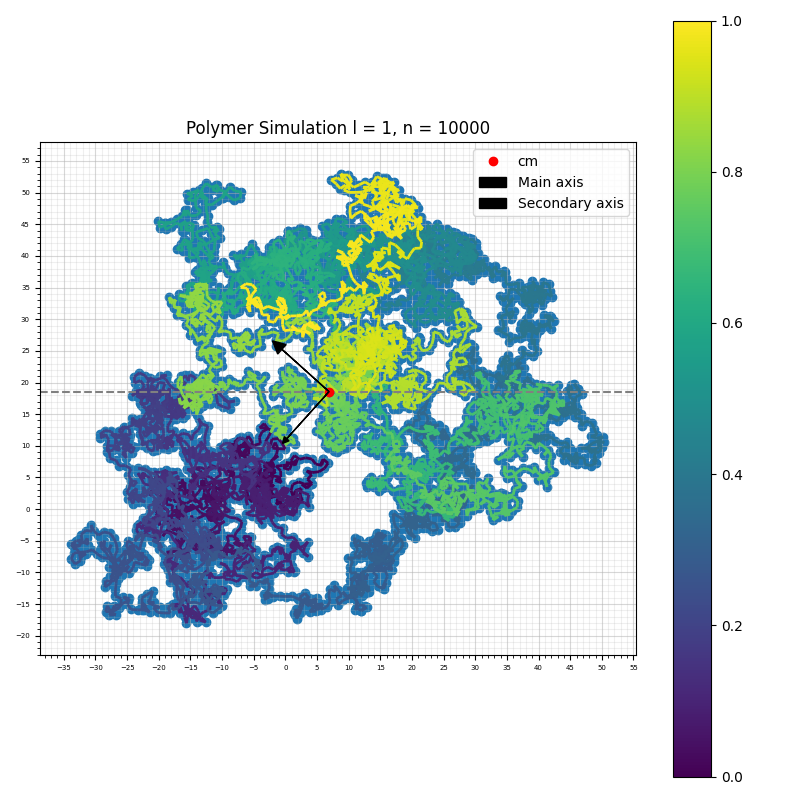

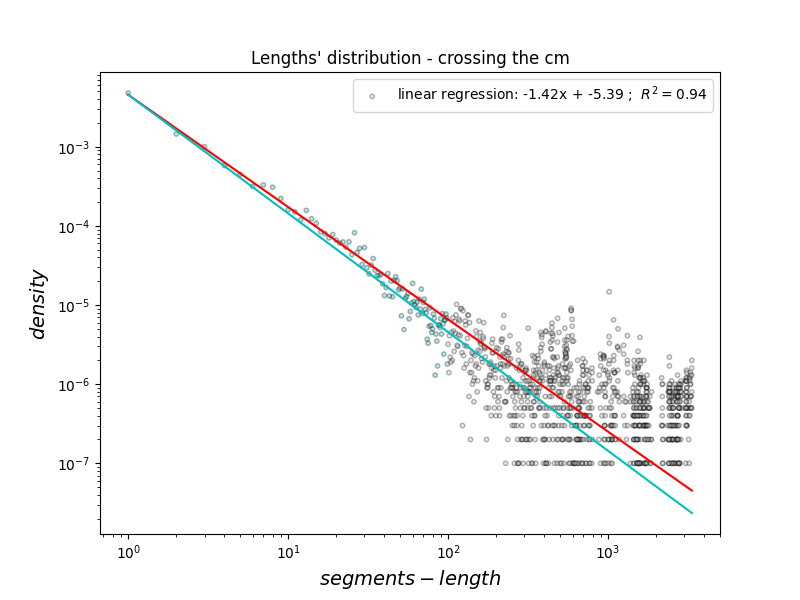

In [47]:
t1 = Test(1000)
print("Test:")
print("Through the cm:")
plt.close('all')
t1.test(p1, True, True, "cm", True, True)

Test:
Through the head:


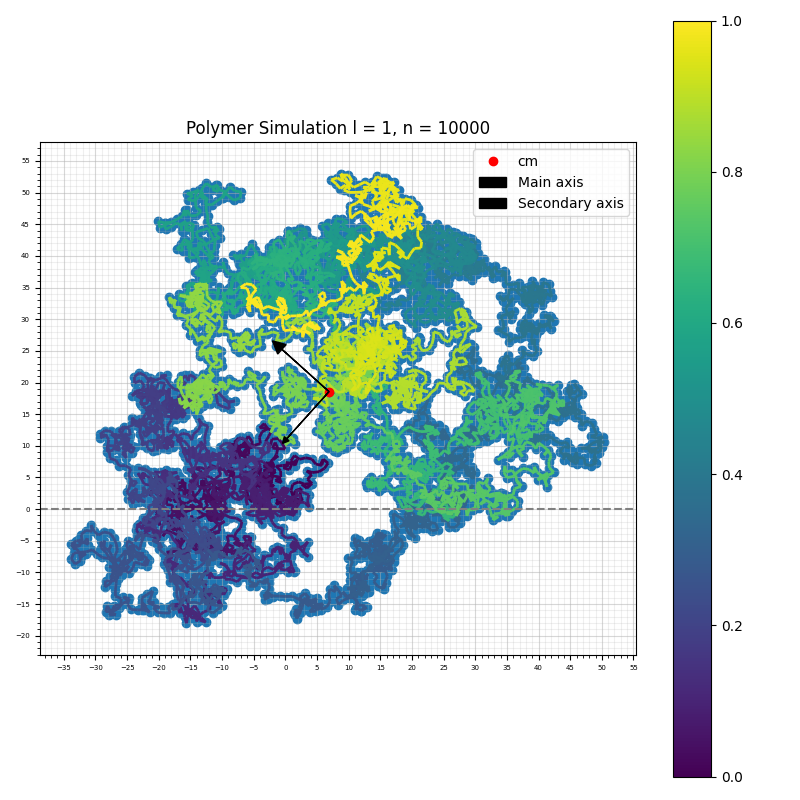

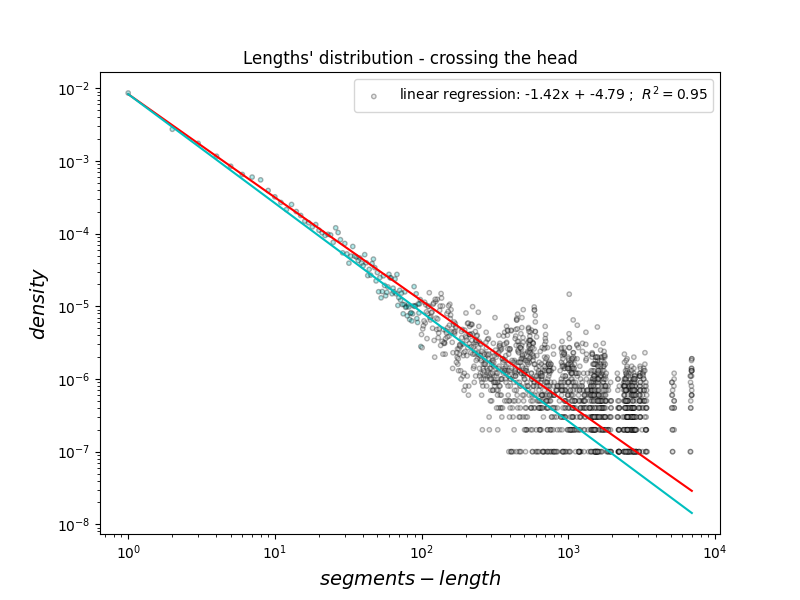

In [48]:
print("Test:")
print("Through the head:")
plt.close('all')
t1.test(p1, True, True, "head", True, True)



---


Histogram of the linear regression first parameter - a:

*   1000 monomers per polymers
*   1000 cuts per polymer
*   1000 polymers




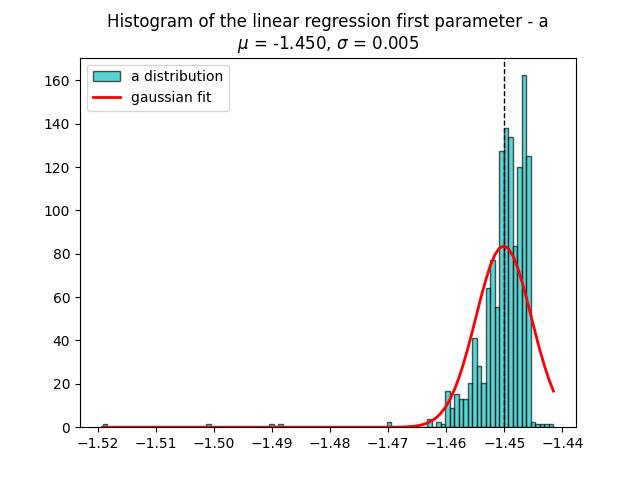

In [50]:
plt.close('all')
t2 = Test(1000)
t2.a_hist(1000, "cm", 1000)



---


Histogram of the linear regression first parameter - a:

*   10000 monomers per polymers
*   100 cuts per polymer
*   100 polymers


In [ ]:
plt.close('all')
t3 = Test(100)
t3.a_hist(10000, "cm",100)



---


Histogram of the linear regression first parameter - a:

*   10000 monomers per polymers
*   1000 cuts per polymer
*   100 polymers


In [ ]:
plt.close('all')
t33 = Test(100)
t33.a_hist(10000, "cm",1000)

---


Histogram of the linear regression first parameter - a:

*   10000 monomers per polymers
*   1000 cuts per polymer
*   100 polymers

In [ ]:
plt.close('all')
t4 = Test(100)
t4.a_hist(10000, "cm", 1000)

---


Histogram of the linear regression first parameter - a:

*   100 monomers per polymers
*   1000 cuts per polymer
*   100 polymers

In [ ]:
plt.close('all')
t5 = Test(100)
t5.a_hist(10000, "cm", 100)

In [ ]:
plt.close('all')
t55 = Test(100)
t55.a_hist(10000, "cm", 100)

In [ ]:
plt.close('all')
s1 = Stat()
s1.is_ideal_random_walk()

First example: the secondary axis dominates the distribution of segments' length

In [ ]:
s1.principle_axes_hist(p1)

Second example: the main axis dominates the distribution of segments' length

In [ ]:
p2 = Polymer(1, 10000)
s1.principle_axes_hist(p2)

In [ ]:
a = t55.a_histogram
n, bins, patches = plt.hist(a,100, density=True ,color='c', edgecolor='k', alpha=0.65, label="a distribution")
plt.axvline(a.mean(), color='k', linestyle='dashed', linewidth=1)
(mu, sigma) = norm.fit(a)
print(a.std())
print(a.var())
y = norm.pdf(bins, mu, sigma)
l = plt.plot(bins, y, '-',color='red', linewidth=2, label="gaussian fit")
plt.title("Histogram of the linear regression first parameter - a\n" + r"$\mu$" + f" = {mu:.3f}, "+ r"$\sigma$" + f" = {sigma:.3f}")
plt.legend()
plt.show()